# Tracing career histories of film directors from IMDb data
*Julie Nguyen, PhD candidate in Management (Organizational Behavior), McGill University*

Welcome to our journey through the world of film, where we aim to unravel the mysteries behind the careers of movie directors! This notebook details the first steps towards understanding if and how connections with network brokers might enable women movie directors to enjoy longer and more impactful careers, and how these effects compare with their men counterparts. 

**What are we aiming to do?**

At this stage, our goal is to build a dataset of all movies released from 2000 to 2023. This dataset will be the backbone for constructing dynamic collaboration networks of filmmakers, with each snapshot of the network capturing their collaboration ties within every three-year period.

Wel'll also construct a unique dataset of movie directors who made their debut from 2003 to 2013. We'll compile their filmographies up to 2023. This way, we ensure that we have at least a decade's view into each director's journey.

Lastly, we'll delve deeper into the pre- and post-debut career paths of these directors. Specifically, we count the number of movies they went on to direct after their debut. We'll also examine their industry involvement before becoming directors. This gives us a sense of how prior experiences in different filmmaking roles may shape their directorial paths.

For these tasks, we'll be using two datasets from IMDb: 'title.basics.tsv.gz' for basic movie information and 'title.principals.tsv.gz' for information on key contributors to each movie. 

**Looking ahead**

These analyses lays the ground work for the second phase: calculating the levels of brokerage social capital of our directors and their collaborators over time.

# Building dataset of movies released between 2000 and 2023 

In this section of the notebook, we will build a comprehensive dataset of movies released between 2000 and 2023.

Let's start by reading in IMDb's data and taking a look at its structure. 

In [78]:
# Importing essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
import os 
from collections import defaultdict
import seaborn as sns
from wordcloud import WordCloud
from numpy import random
import seaborn as sns

# Setting the working directory to where project files are located.
# This helps in organizing project files and ensures relative paths work correctly.
os.chdir('/Users/mac/Library/CloudStorage/OneDrive-McGillUniversity/Work/Projects/Gender and brokerage/WomenLeaders_SocialNetworks')

In [8]:
# Defining URLs of the IMDb data files.
# IMDb provides open datasets for basic title information and title principals (major contributors).
url_basics = 'https://datasets.imdbws.com/title.basics.tsv.gz'
url_principals = 'https://datasets.imdbws.com/title.principals.tsv.gz'

# Loading the datasets directly from IMDb's servers.
# This approach ensures we're working with the most up-to-date information available.
# The datasets are in TSV (Tab-Separated Values) format and compressed with gzip.
df_basics = pd.read_csv(url_basics, sep='\t', compression='gzip', encoding='utf-8', low_memory=False)
df_principals = pd.read_csv(url_principals, sep='\t', compression='gzip', encoding='utf-8', low_memory=False)

In [40]:
# Displaying the first few rows of the 'df_basics' DataFrame to understand the structure of the dataset.
# This initial look helps in planning how to filter and process the data for our analysis.
df_basics.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894.0,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892.0,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892.0,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892.0,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893.0,\N,1,"Comedy,Short"


In [41]:
# Analyzing the distribution of values in 'titleType' and 'isAdult' columns.
# Understanding these distributions is crucial for filtering the dataset to movies only and excluding adult content.
{col: df_basics[col].value_counts() for col in ['titleType', 'isAdult']}

{'titleType': titleType
 tvEpisode       8042282
 short            974875
 movie            669892
 video            287189
 tvSeries         256237
 tvMovie          144193
 tvMiniSeries      52188
 tvSpecial         45647
 videoGame         37276
 tvShort           10240
 tvPilot               1
 Name: count, dtype: int64,
 'isAdult': isAdult
 0       10185807
 1         334195
 2023           6
 2019           3
 2020           2
 1981           1
 2017           1
 \N             1
 2022           1
 2011           1
 2014           1
 2005           1
 Name: count, dtype: int64}

Our next step is to clean and prepare the data for analysis. This involves filtering out irrelevant entries (such as adult movies) and ensuring that our dataset only includes movies with valid start years.

In [9]:
# Converting 'startYear' column to numeric values.
# Non-numeric entries (errors) are converted to NaN (Not a Number), which simplifies filtering later on.
df_basics['startYear'] = pd.to_numeric(df_basics['startYear'], errors='coerce')

# Filtering the dataset to include only non-adult movies with a valid start year.
# This step is essential for focusing our analysis on relevant movies.
movies = (df_basics
          .query('titleType == "movie" & isAdult == "0" & startYear == startYear') 
          .filter(items=['tconst', 'startYear', 'genres'])  
          )

# Displaying the number of unique values in each column of the 'movies' DataFrame
movies.nunique()

tconst       563624
startYear       135
genres         1338
dtype: int64

As of the time of this analysis (Jan 29, 2024), the data includes 563,624 non-pornographic movies spaning 135 years. What are the earliest and latest year covered by IMDb's data?

In [10]:
# Determining the range of years covered in our filtered dataset.
# This information helps in understanding the temporal span of our data.
print("Earliest Year:", movies['startYear'].min())
print("Latest Year:", movies['startYear'].max())

Earliest Year: 1894.0
Latest Year: 2031.0


The earliest year we have data on is 1894 and the latest year 2031. Seems like IMDb has info on movies that have not been released yet, which we'll remove from our data. And then we'll visualize trends in the number of movies released each year to understand how the movie industry has evolved and identify any significant patterns or anomalies.

In [ ]:
# Excluding movies released after 2023 to align with the study's timeframe.
movies = movies[movies['startYear'] <= 2023]

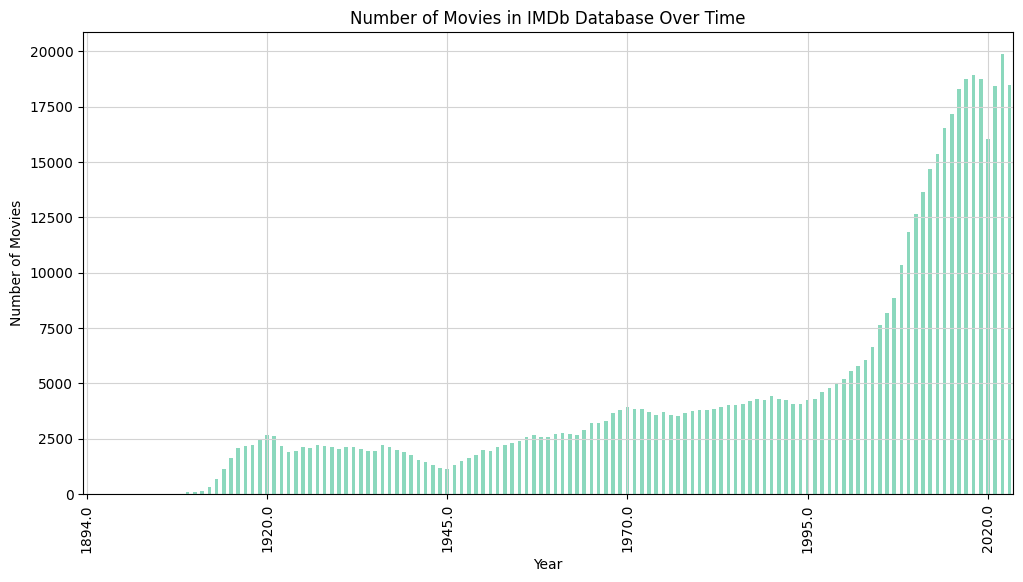

In [74]:
# Aggregating the number of movies released each year.
# This aggregation helps in visualizing trends in movie production over time.
movies_per_year = movies.groupby('startYear').size()

# Plotting the annual movie counts to visually analyze trends in movie production.
plt.figure(figsize=(12,6))
movies_per_year.plot(kind='bar', color='#8BD8BD')
plt.title('Number of Movies in IMDb Database Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.xticks(range(0, len(movies_per_year), 25), labels=movies_per_year.index[::25]) # Adjust x-axis to show labels for every 25 years
plt.grid(True, color='#D3D3D3')  # Adding light grey grid lines for better readability
plt.show()


A lot more movies are made in the 21st century than previous centuries. This is probably due to the spread of the internet in the late 90s, which led to a shift towards digital filmmaking and distribution. This technological advancement made it easier and more cost-effective to produce and distribute films. To have a representative look at what the movie industry looks like today, we'll focus on movies released in this century, i.e., from 2000 to 2023 (present year).

In [30]:
# Narrowing down the dataset to include movies released from 2000 to 2023.
# This will serve as the data to build the film-maker collaboration network later on
movies_2000_2023 = movies[(movies['startYear'] >= 2000) & (movies['startYear'] <= 2023)]

# Displaying the first few rows of this subset
movies_2000_2023.head()

,tconst,startYear,genres
11634,tt0011801,2019.0,"Action,Crime"
13079,tt0013274,2021.0,Documentary
15174,tt0015414,2000.0,\N
27745,tt0028248,2022.0,Musical
34798,tt0035423,2001.0,"Comedy,Fantasy,Romance"


In [31]:
# Counting unique values in each column of our final dataset.
# This step provides insights into the diversity of data we'll be working with.
movies_2000_2023.nunique()

tconst       313675
startYear        24
genres         1192
dtype: int64

We now have 313,675 movies made between 2000 and 2023, with information on each movie's ID (`tconst`), release year (`startYear`), and genres (`genres`). Before moving on to the next stage of analysis, we save this dataset to a CSV file so that we can use it later to construct a dynamic collaboration network among film-makers from 2000 to 2023. 

In [32]:
# Saving the DataFrame to a CSV file for future use
# 'index=False' omits the index column in the saved file
movies_2000_2023.to_csv('movies_2000_2023.csv', index=False)

# Visualization to understand movies data better 

Let's also create some visualizations to explore different trends in the film industry, such as movie release frequency, genre popularity, and the evolution of genre preferences over time.

## Movie releases over time

First, let's visualize the trend in movie releases over time. For this, we group movies by their release year, count the occurrences, and create a bar chart for movie releases in each year. From this graph, we can observe fluctuations in movie production and potentially relate these with historical events, technological advancements, or shifts in consumer behavior.

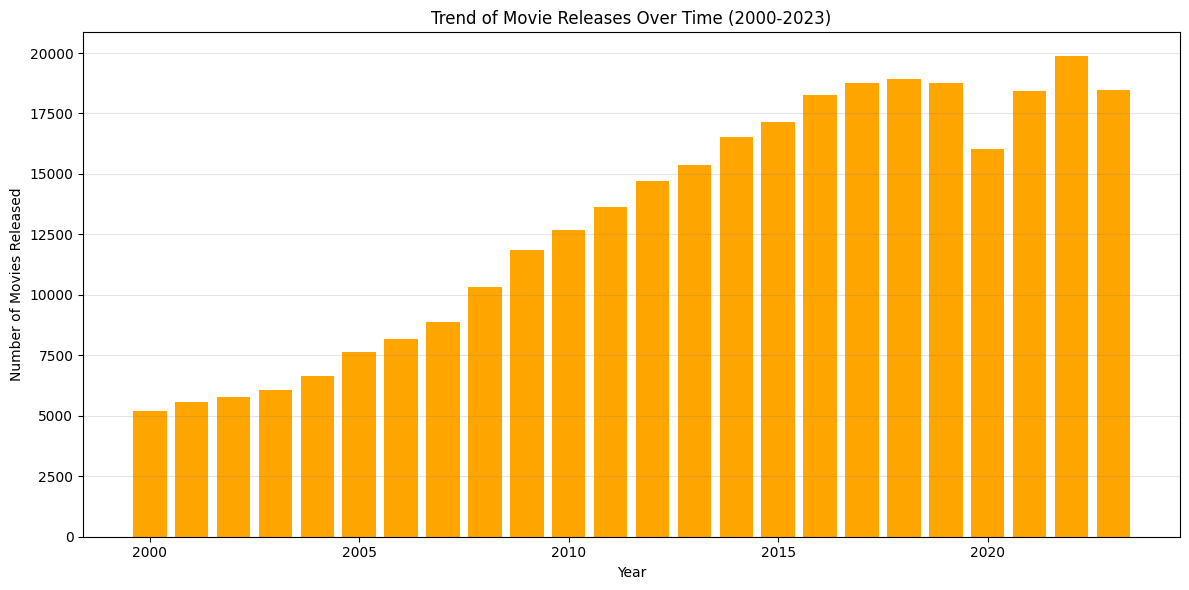

In [6]:
# Group by startYear and count the number of movies to understand the annual production trends.
movies_by_year = movies_2000_2023.groupby('startYear').size()

# Plotting a bar chart to visually represent the number of movies released each year.
plt.figure(figsize=(12, 6))
plt.bar(movies_by_year.index, movies_by_year.values, color='orange')
plt.title('Trend of Movie Releases Over Time (2000-2023)')
plt.xlabel('Year')
plt.ylabel('Number of Movies Released')
plt.grid(axis='y', color='grey', alpha=0.2) # Add a light grid for better readability.
plt.tight_layout()
plt.show()

The number of movie releases steadily increases every year, except for in 2020 where we see a dip. This is probably due to the COVID-19 pandemic that began in late 2019 and continued into the following years. Many movie productions were paused, and theaters closed, leading to a significant decrease in movie releases in 2020. However, in 2021, the number of movie releases went up again and by 2023, it is now at the levels before the pandemic. This is partly thanks to the shift towards streaming platforms, introducing a new venue for film debuts.

It is also interesting to see that the 2007-2008 Writers Guild of America strike and the 2008 economic recession did not seem to have a dampening effect on the number of movie releases, with this number still rising annually throughout this period. 

## Genre distribution 

Next, let's visualize the distribution of movie genres across all years in the data. For this, we'll calculate the percentage of movies in each genre relative to the total number of movies released and then use a donut chart and a word cloud highlighting the most common genres. We'll first do this for all years and then separately for each decade in the data. These visualizations give us a sense of the most popular genres and shifts in genre preferences over decades.

In [ ]:
# Preparing data for genre distribution visualization

# Splitting the genres column into lists to facilitate filtering of genres.
movies_2000_2023['genres'] = movies_2000_2023['genres'].str.split(',')

# Removing movies with empty genre lists to ensure all movies considered have relevant genres.
movies_2000_2023 = movies_2000_2023[movies_2000_2023['genres'].map(bool)]

# Expanding the genres column so that each genre of a movie is treated as a separate data point.
expanded_genres = movies_2000_2023.explode('genres')

# Exclude movies with unspecified genres (represented by '\N').
expanded_genres = expanded_genres[expanded_genres['genres'] != '\\N']

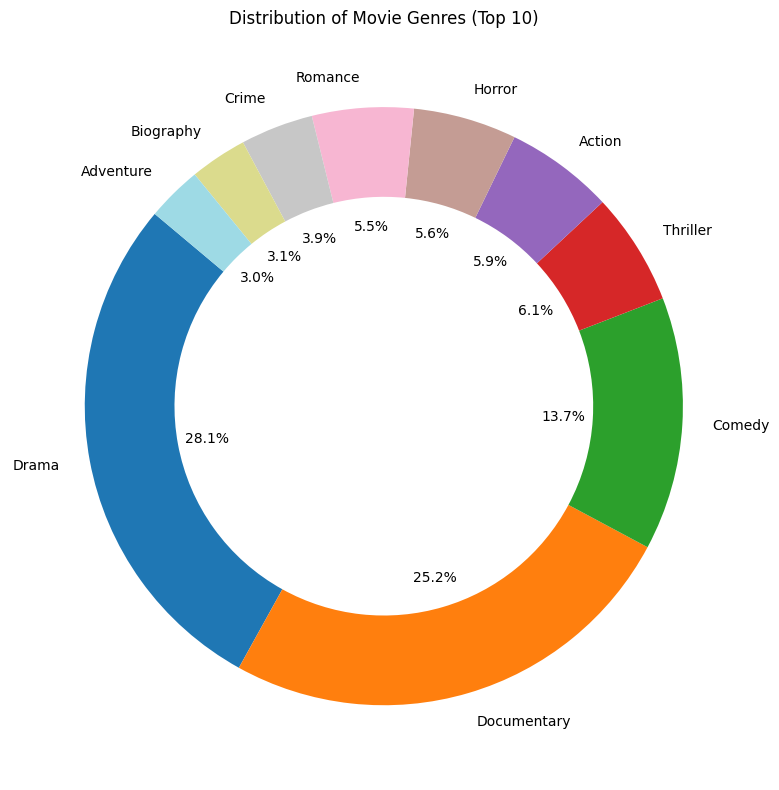

In [64]:
# Genre distribution (top 10 genres) visualization

# Calculating the distribution of genres across all years to understand popular trends.
genre_distribution = expanded_genres['genres'].value_counts(normalize=True) * 100

# Focusing on the top 10 genres for a clearer visualization.
top_genres = genre_distribution.head(10)

# Assigning unique colors to each of the top genres for visual distinction.
unique_colors = plt.cm.tab20(np.linspace(0, 1, len(top_genres)))

# Plotting a donut chart to visualize the proportion of top genres, using 'wedgeprops' to create the donut effect.
plt.figure(figsize=(8, 8))
plt.pie(top_genres, labels=top_genres.index, autopct='%1.1f%%', startangle=140, colors=unique_colors, wedgeprops=dict(width=0.3))
plt.title('Distribution of Movie Genres (Top 10)')

plt.tight_layout()
plt.show()


It seems like drama, documentary, and comedy are the most popular genres. 

In addition to donut chart, we can also use word cloud to visualize the distribution of genres within the dataset, where the size of each genre's name corresponds to its frequency. The larger the genre name appears in the Word Cloud, the more frequently it occurs in the dataset, indicating its popularity or commonality in movie production. 

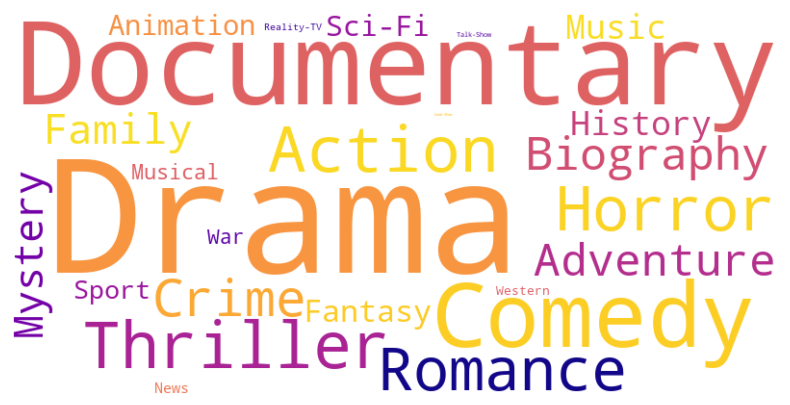

In [62]:
# Word cloud visualization

# Calculate the frequency of each genre in the dataset to understand genre prevalence.
genre_frequencies = expanded_genres['genres'].value_counts().to_dict()

# Create a word cloud visualization using the frequencies dictionary. Here, we use size to indicate the relative frequency of each genre
wordcloud = WordCloud(width=800, height=400, background_color ='white', colormap='plasma').generate_from_frequencies(genre_frequencies)

# Display the word cloud using matplotlib, setting interpolation to 'bilinear' for smoothness.
# The axis is turned off to focus solely on the word cloud visualization.
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove axis for cleaner visualization
plt.show()

Let's see if Drama, Documentary, and Comedy remain the most popular genres over time. For this, we'll create three donut charts, each corresponding to a different decade: the 2000s (2000-2009), the 2010s (2010-2019), and the early 2020s (2020-2023). We will place them in a single row to allow for a direct comparison of movie genre distributions across the three distinct periods, highlighting how the popularity of top genres has evolved over the past two-plus decades.

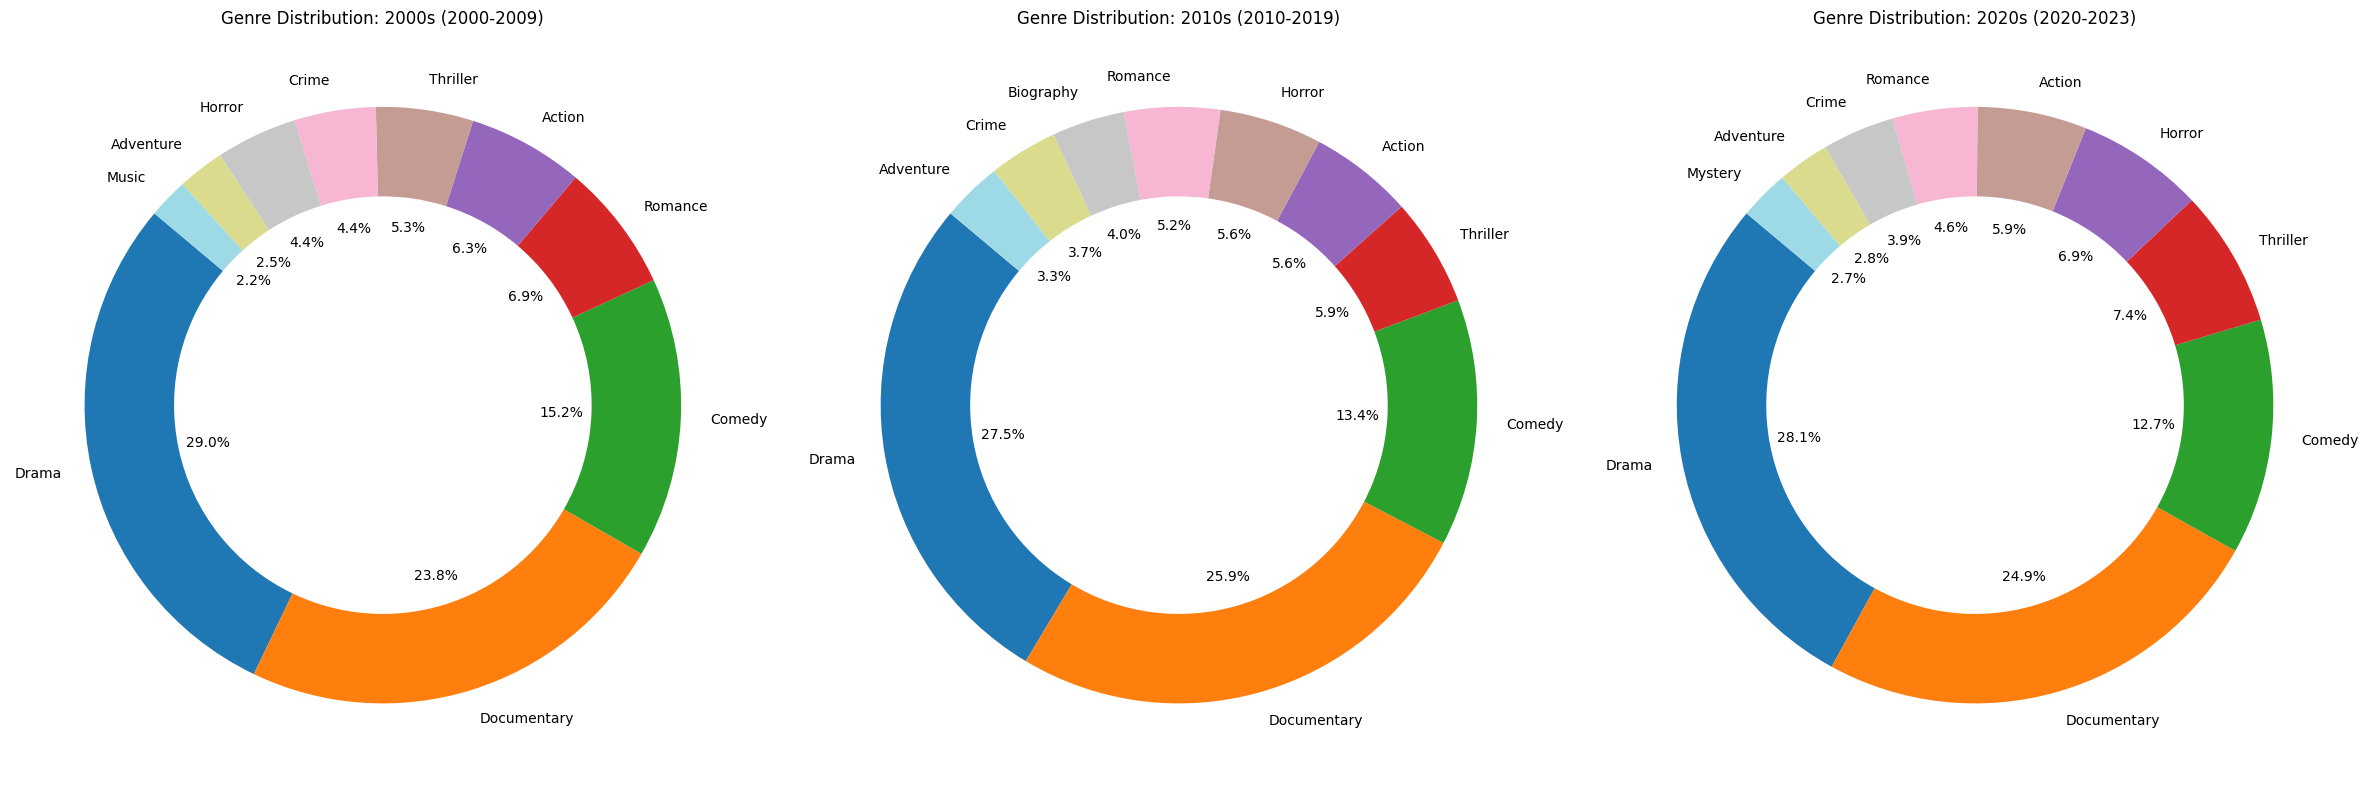

In [48]:
# Time-segmented genre distribution visualization

# Define consolidated time periods for creating segmented donut charts. This categorization allows
# us to compare genre distributions across different eras within our dataset, highlighting how
# genre preferences have evolved over time.
consolidated_periods = {
    '2000s (2000-2009)': (2000, 2009),
    '2010s (2010-2019)': (2010, 2019),
    '2020s (2020-2023)': (2020, 2023),
}

# Prepare the figure for the donut charts with a subplot for each time period defined above.
# This arrangement facilitates direct visual comparison between different eras.
fig, axs = plt.subplots(1, len(consolidated_periods), figsize=(24, 8))  # One row, with a subplot for each time period

# Iterate through each time period, filtering the data accordingly and calculating the top genres for that period.
for idx, (period_label, (start_year, end_year)) in enumerate(consolidated_periods.items()):
    # Filter the data for the current time period
    period_data = expanded_genres[(expanded_genres['startYear'] >= start_year) & (expanded_genres['startYear'] <= end_year)]
    
    # Calculate genre distribution for the current period to identify the most popular genres.
    genre_distribution_period = period_data['genres'].value_counts(normalize=True) * 100
    top_genres_period = genre_distribution_period.head(10)
    
    # Generate unique colors for each genre to enhance visual distinction in the donut chart.
    unique_colors_period = plt.cm.tab20(np.linspace(0, 1, len(top_genres_period)))
    
    # Plotting a Donut Chart for the current period with custom colors and a wedge to denote segmentation.
    # Each chart represents the genre distribution within its respective time period.
    axs[idx].pie(top_genres_period, labels=top_genres_period.index, autopct='%1.1f%%', startangle=140, colors=unique_colors_period, wedgeprops=dict(width=0.3))
    axs[idx].set_title(f'Genre Distribution: {period_label}')

# Adjust the layout to ensure that each donut chart is clearly visible and the overall visualization is well-organized. 
plt.tight_layout()
plt.show()

It seems like Drama, Documentary, and Comedy remain the most popular genres over time. Although there are also some fluctuations. For example, the fourth and fifth most popular genres in the 2000s are Comedy and Romance, while in the 2010s they are Thriller and Action (reflecting the rise of superhero movies and the decline of romantic comedy movies?). In the early 2020s, they are Thriller and Horror.

## Change in genre popularity

To understand the exact percentage change in genre popularity between the years 2000 and 2023, let's create a horizontal bar chart with genres that have seen an increase in percentage displayed on the left and those with a decrease on the right. Each bar represents a different genre, with the length of the bar indicating the magnitude of the change in percentage. Blue bars denote increases in popularity, while red bars indicate decreases. The central line at the 0 point on the x-axis serves as a reference point, making it easy to discern the direction of change for each genre. This gives us a better sense of which genres have become more or less prevalent.

In [25]:
# Counting the number of movies in each genre per year for later analysis of genre popularity changes.
genre_counts_per_year = expanded_genres.groupby(['startYear', 'genres']).size().unstack(fill_value=0)

# Calculating percentages of movies in each genre relative to the total number of movies released that year to understand their relative popularity over time.
genre_percentages_per_year = genre_counts_per_year.div(genre_counts_per_year.sum(axis=1), axis=0) * 100

# Identifying the percentage change for each genre from the first to the last year to spot trends.
first_year_percentage = genre_percentages_per_year.iloc[0]
last_year_percentage = genre_percentages_per_year.iloc[-1]
percentage_change = last_year_percentage - first_year_percentage

# Sort genres by the change to ensure a coherent plot
percentage_change_sorted = percentage_change.sort_values()

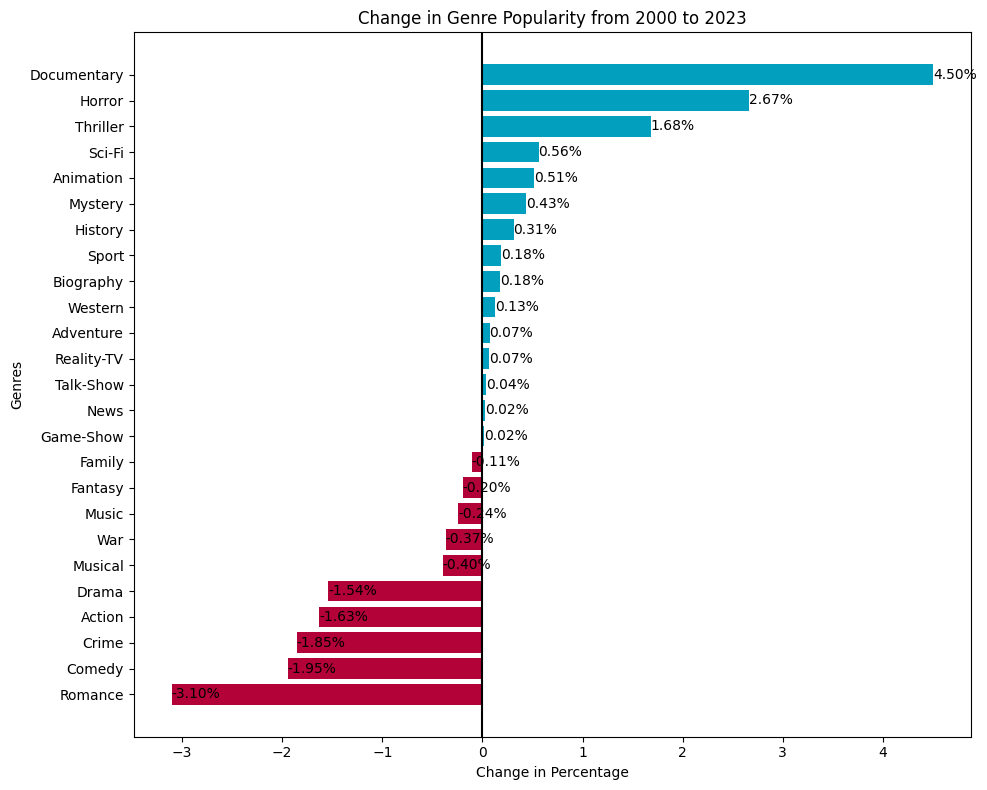

In [32]:
# Plotting a horizontal bar chart to illustrate the change in popularity for each genre.
plt.figure(figsize=(10, 8))
bars = plt.barh(percentage_change_sorted.index, percentage_change_sorted.values, color=np.where(percentage_change_sorted > 0, '#039fbe', '#b20238'))
plt.axvline(0, color='black', linewidth=1.5)  # Marking the no-change point for reference.
plt.title('Change in Genre Popularity from 2000 to 2023')
plt.xlabel('Change in Percentage')
plt.ylabel('Genres')

# Adding labels to indicate increase or decrease
for bar in bars:
    width = bar.get_width()
    label_x_pos = bar.get_width() if bar.get_width() < 0 else bar.get_width()
    plt.text(label_x_pos, bar.get_y() + bar.get_height()/2, f"{'%.2f' % width}%", va='center')

plt.tight_layout()
plt.show()

Looks like Documentaries, Horror, and Thriller have seen an increase in popularity over the years, while Action, Comedy, Crime, Drama, and Romance have seen a decrease in their relative popularity. The rest of the genres have remained relatively stable.

However, it is worth noting that although the percentage of Drama, Comedy, Action movies has decreased over time, these genres are still extremely popular today, ranking 1st, 3rd, and 7th in terms of popularity as seen in the donut chart for the years 2020-2023 above. 

# Comparison of movie releases by genre

We can also get a sense of which genres have been consistently popular and which have seen significant fluctuations. For this, we use a violin plot to compare the distribution of the number of movies released across different genres each year.

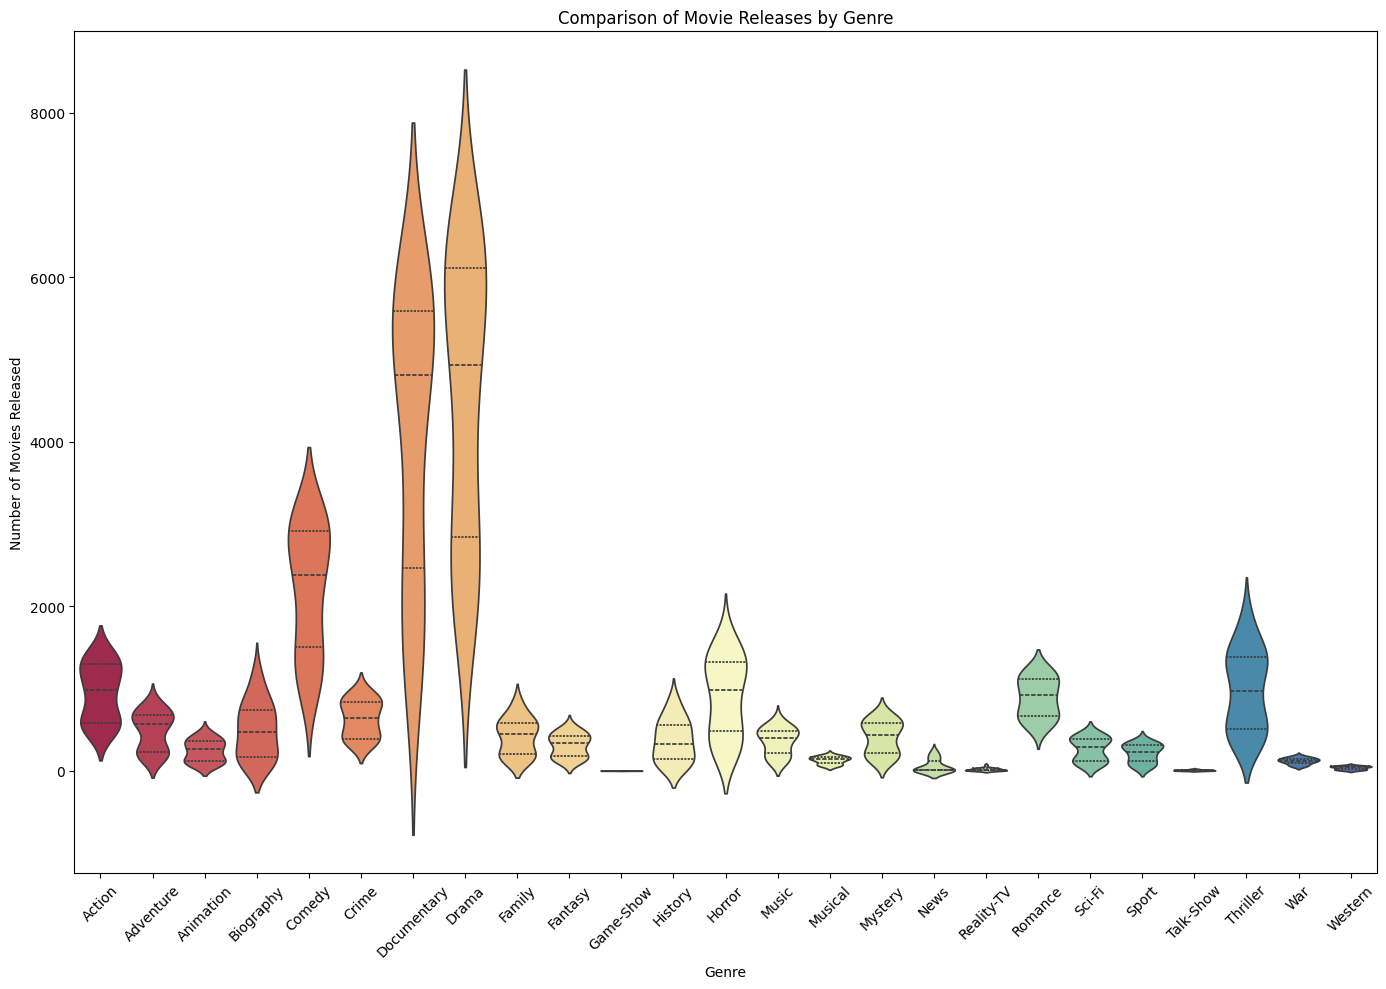

In [54]:
# visualize the comparison of movie releases by genre using a violin plot

# Counting the number of movies in each genre per year 
genre_year_distribution = expanded_genres.groupby(['genres', 'startYear']).size().reset_index(name='MovieCount')

# Create the violin plot
plt.figure(figsize=(14, 10))
sns.violinplot(data=genre_year_distribution, x='genres', y='MovieCount', density_norm='width', inner='quartile', palette="Spectral",
               hue='genres', legend=False)
plt.xticks(rotation=45)
plt.title('Comparison of Movie Releases by Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Movies Released')
plt.tight_layout()
plt.show()

The genres with highest variability (those with broad violins at the median and long tails) are Drama, Documentary, and, to a lesser extent, Comedy. This means that they have had years of both high and low productions, indicating fluctuations in popularity. Despite their high variability, they remain highly popular across time, indicated by high median values of movies per year. 

Action, Horror, Romance, and Thriller, while not topping the list in median releases, show significant production levels with high median releases, indicating their steady popularity.

Ok now that we understand the movie data a bit better, let's move on to the next phase of the project - building a dataset covering the full filmography of movie directors. 

# Identifying first-time directors and tracking full filmography 

In this section of our notebook, we'll identify film directors who made their debut between 2003 and 2013 and compile the full filmography of these directors up to present day (the year 2023). 

Let's start by looking at the `df_principals` DataFrame, which provides a comprehensive list of key contributors to films listed in the IMDb database. 

In [42]:
# Initial Exploration of Principal Contributors Data
# The 'df_principals' DataFrame contains key contributors to movies, including directors, actors, etc.
# Viewing its structure helps us understand how to extract information specific to directors.
df_principals.head()

,tconst,ordering,nconst,category,job,characters
0,tt0000001,1,nm1588970,self,\N,"[""Self""]"
1,tt0000001,2,nm0005690,director,\N,\N
2,tt0000001,3,nm0374658,cinematographer,director of photography,\N
3,tt0000002,1,nm0721526,director,\N,\N
4,tt0000002,2,nm1335271,composer,\N,\N


Looks like the data includes information on who (`nconst`) worked on which movie (`tconst`) in which capacity (`category`). Let's also examine the frequency of different roles to get a sense of the diversity of roles in film-making.

In [43]:
# Understanding the Roles in Film Production
# By analyzing the 'category' column, we identify the distribution of different roles within movie productions.
# This is crucial for isolating directors from other types of contributors in the dataset.
df_principals['category'].value_counts()

category
actor                  13322849
self                   10448069
actress                10392402
writer                  8435856
director                6951076
producer                3917208
cinematographer         2050878
editor                  1996902
composer                1996779
archive_footage          397891
production_designer      381792
archive_sound              4516
Name: count, dtype: int64

Now, we filter the DataFrame to include only directors and then merge this information with the `movies` DataFrame to link directors to their films. Next, we'll identify the debut year of these directors to find those who started their journey in the years between 2003 and 2013.

In [37]:
# Isolating Directors
# We filter 'df_principals' to focus only on entries categorized as 'director'.
# This step is essential for later linking directors to their respective movies.
directors = df_principals[df_principals['category'] == 'director']

# Linking Directors to Their Movies
# We merge the 'movies' DataFrame with the filtered 'directors' DataFrame using the 'tconst' identifier.
# This enables us to attribute movies to specific directors 
directors = movies.merge(directors[['tconst', 'nconst']], on='tconst', how='inner')

# Identifying Directors' Debut Films
# By grouping the data by director and finding the earliest 'startYear', we identify each director's debut film.
directors_first_movies = directors.groupby('nconst').agg({'startYear': 'min'}).reset_index()

# Renaming the aggregated column to denote it as the year of the director's first movie
directors_first_movies = directors_first_movies.rename(columns={'startYear': 'firstYear'})

# Focusing on Directors Who Debuted Between 2003 and 2013
# We filter directors to include only those whose debut falls within our period of interest.
# This selection allows us to have at least a decade view into a director's career
debut_directors_2003_2013 = directors_first_movies[(directors_first_movies['firstYear'] >= 2003) & (directors_first_movies['firstYear'] <= 2013)]

# Compiling Full Filmographies
# By filtering the 'directors' DataFrame for our identified debut directors, we compile their complete filmographies.
directors_full_filmography = directors[directors['nconst'].isin(debut_directors_2003_2013['nconst'])]

# Merging with debut information allows us to retain knowledge of each director's first year in the industry.
directors_full_filmography = directors_full_filmography.merge(debut_directors_2003_2013, on='nconst', how='left')

In [55]:
# Counting the unique counts for an overview of the compiled filmographies
directors_full_filmography.nunique()

tconst       115413
startYear        21
genres          948
nconst        63169
firstYear        11
dtype: int64

So, our sample includes 63,169 directors. Next, let's integrate IMDb ratings and vote counts into our filmography dataset to get a sense of the popularity and reception of the movies made by these directors.

In [56]:
# Integrating IMDb Ratings
# Accessing and merging IMDb's 'title.ratings' dataset enhances our filmography data with public reception metrics.
# This inclusion of ratings and votes offers an additional layer of analysis for evaluating directors' works.
url_ratings = 'https://datasets.imdbws.com/title.ratings.tsv.gz'
df_ratings = pd.read_csv(url_ratings, sep='\t', compression='gzip')

# Displaying the first few rows of 'df_ratings' for an overview
df_ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,2017
1,tt0000002,5.7,270
2,tt0000003,6.5,1943
3,tt0000004,5.4,178
4,tt0000005,6.2,2721


In [57]:
# Merge the ratings data with the 'directors_full_filmography' dataset
# This adds IMDb ratings and number of votes to the filmography data
directors_full_filmography = directors_full_filmography.merge(df_ratings, on='tconst', how='left')

# Save the 'directors_full_filmography' dataset to a CSV file for future use
directors_full_filmography.to_csv('directors_full_filmography.csv', index=False)

In [3]:
directors_full_filmography

,tconst,startYear,genres,nconst,firstYear,averageRating,numVotes
0,tt0108549,2004.0,"Comedy,Mystery",nm1131265,2004.0,7.8,34.0
1,tt0108549,2004.0,"Comedy,Mystery",nm1130611,2004.0,7.8,34.0
2,tt0117461,2003.0,"Comedy,Romance",nm0290651,2003.0,6.3,24.0
3,tt0117743,2008.0,"Drama,Romance",nm0404033,2003.0,6.7,64.0
4,tt0118141,2005.0,Drama,nm0000417,2005.0,5.3,950.0
...,...,...,...,...,...,...,...
128529,tt9916362,2020.0,"Drama,History",nm1893148,2008.0,6.4,5687.0
128530,tt9916538,2019.0,Drama,nm4457074,2011.0,8.6,7.0
128531,tt9916622,2015.0,Documentary,nm9272490,2012.0,NaN,NaN
128532,tt9916754,2013.0,Documentary,nm9272490,2012.0,NaN,NaN


# Visualization to understand director filmography better 

With the data on directors' full filmography in hand, we can create visualizations to uncover patterns in their career progressions following their debut, the genres they explore, and how their work is received by audiences.

## Number of movies directed after debut

First, let's create a bar chart visualizing the count of movies directed by these directors after their debut. This visualization categorizes directors based on their productivity post-debut, highlighting how many have gone on to direct additional films. It a sense of directorial activity beyond the debut, indicating the range of career trajectories—from those who may not direct again to those who become prolific directors.

In [4]:
# Initialize a DataFrame to track each director's career progression after their debut.
# It includes a unique identifier for each director ('nconst') and their debut year ('firstYear').
post_debut_director_movies = directors_full_filmography[['nconst', 'firstYear']].drop_duplicates()

# Initially assume all directors have directed zero movies after their debut
# This assumption will be updated based on the actual data 
post_debut_director_movies['movies_directed_after_first'] = 0

# Filter the full filmography to include only movies directed after the director's first movie
# This helps in focusing on the directors' career progression after their debut
movies_after_debut = directors_full_filmography[directors_full_filmography['startYear'] > directors_full_filmography['firstYear']]

# Group the data by director and count the number of movies directed after their debut
movies_count_after_debut = movies_after_debut.groupby('nconst').size()

# Update our initial DataFrame with these counts to reflect directors' productivity after their debut.
post_debut_director_movies.set_index('nconst', inplace=True)
post_debut_director_movies.loc[movies_count_after_debut.index, 'movies_directed_after_first'] = movies_count_after_debut
post_debut_director_movies.reset_index(inplace=True)

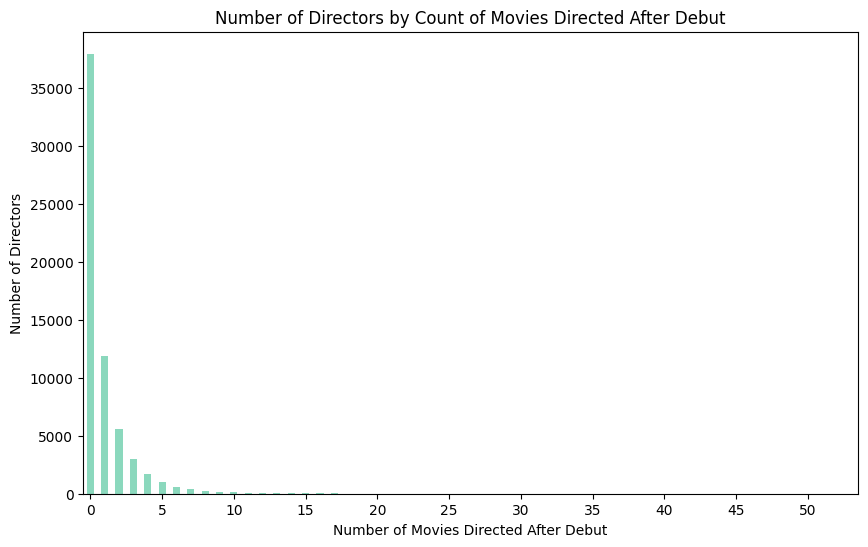

In [5]:
# Visualize the productivity of directors after their debut by counting the number of movies directed.
plt.figure(figsize=(10, 6))
director_counts_by_movie_number = post_debut_director_movies['movies_directed_after_first'].value_counts().sort_index()
director_counts_by_movie_number.plot(kind='bar', color='#8BD8BD')

# Adding labels and title
plt.title('Number of Directors by Count of Movies Directed After Debut')
plt.xlabel('Number of Movies Directed After Debut')
plt.ylabel('Number of Directors')

# Adjust the x-axis to show labels for every 5 movies for better readability
xticks = range(0, len(director_counts_by_movie_number), 5)
plt.xticks(ticks=xticks, labels=[str(i) for i in xticks], rotation=0)

plt.show()

Wow, it looks like a significant portion of directors do not continue to direct movies after their debut. Let's generate some descriptive statistics on the number of movies directed to get a better sense of their productivity. 

In [6]:
# Get an overview of the distribution and central tendencies of the number of movies directed after debut
post_debut_director_movies['movies_directed_after_first'].describe()

count    63169.000000
mean         1.010021
std          2.359699
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max        126.000000
Name: movies_directed_after_first, dtype: float64

Things seem stark in the film industry. The median and mode being 0 indicate that at least half of the directors did not produce any movie post-debut. The third quartile is 1, suggesting that 75% of directors directed one movie or fewer after their debut.

A large standard deviation, alongside a wide range, points to a significant disparity in career trajectories among directors, with a few directors being exceptionally prolific, which skews the average slightly higher than the median and mode.

Overall, this shows that while there is a small group of directors who achieved exceptional productivity, the overall picture is one of considerable challenge with most directors do not continue to direct movies after their debut, highlighting the competitive and challenging nature of a directorial career. ​​

## Genre distribution among debut directors

Next, let's create a visualization showing which genres are more commonly chosen a for directorial debut. For this, we'll identify the genres of each director's debut movie and create a heatmap showing the prevalence of each genre among debut movies. The color intensity represents the count of directors who debuted with movies in specific genres, with warmer colors indicating higher frequencies.

This visualization tells us trends in genre popularity among new directors and suggest genres that are seen as accessible or appealing for directorial debuts.

In [35]:
# Prepare the data for visualization of genre distribution among directors in their debut movie

# Filter to get only the debut movies for each director
debut_movies = directors_full_filmography[directors_full_filmography.groupby('nconst')['startYear'].transform('min') == directors_full_filmography['startYear']]

# Since a movie can have multiple genres, we need to expand the dataset so that each genre gets its own row
genres_expanded = debut_movies.drop('genres', axis=1).join(debut_movies['genres'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('genre'))

# Count how frequently each genre appears in directors' debut movies.
genre_distribution = genres_expanded.groupby('genre').size()

# Convert the series to a DataFrame for visualization
genre_distribution_df = genre_distribution.reset_index(name='count').pivot_table(index='genre', values='count', aggfunc='sum')

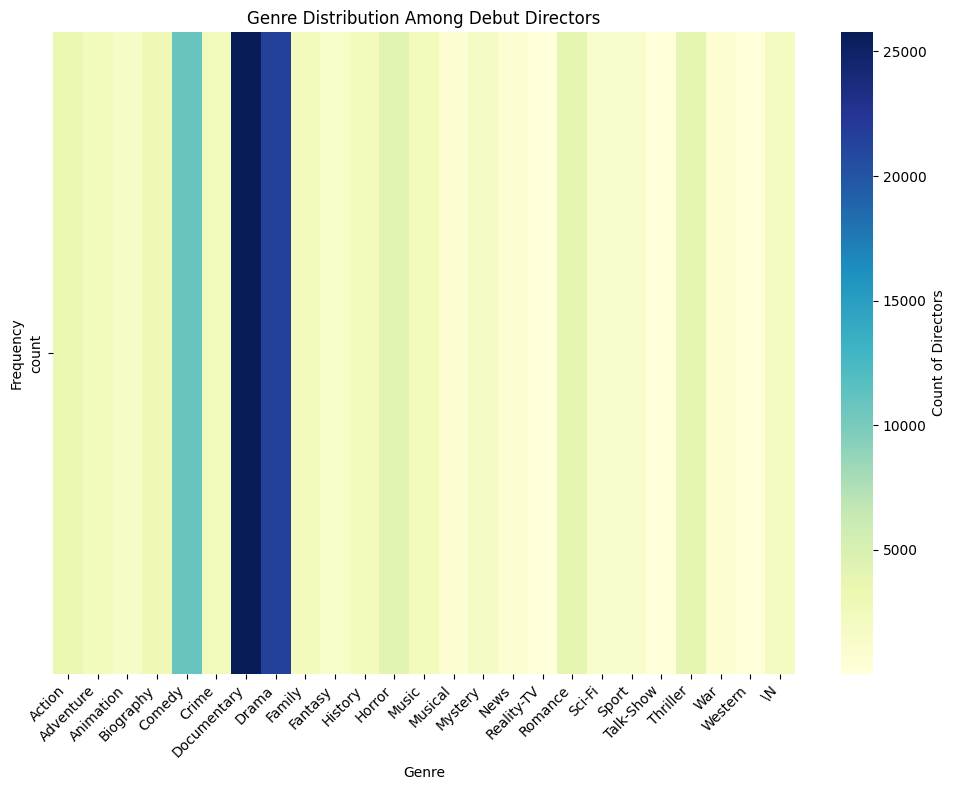

In [39]:
# Create a heatmap to visualize the distribution of genres among debut movies, offering insight into popular genres for debut directors.
plt.figure(figsize=(10, 8))
sns.heatmap(genre_distribution_df.T, cmap='YlGnBu', cbar_kws={'label': 'Count of Directors'})

plt.title('Genre Distribution Among Debut Directors')
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Genres like Documentary, Drama, and Comedy appear to be popular choices for debut movies, suggesting these genres might be more accessible or appealing for new directors. Horror, Thriller, and Romance, to a lesser extent, are also popular choices for new directors.

## Ratings by genres among debut movies

Does this mean debut movies in these genres also get high ratings? To get at this, we can use a box plot to compare the average ratings across genres. Each box represents the interquartile range (IQR) of ratings within a genre, with the line inside the box marking the median rating. 

This visualization helps us understand which genres among debut movies tend to receive higher or lower ratings, providing insights into the success of various genres and how well they resonate with audiences.

In [68]:
# Prepare the data for the box plot visualization
# Since movies can have multiple genres, we expand the dataset so each genre of a movie is considered separately
genres_expanded_ratings = debut_movies.drop('genres', axis=1).join(debut_movies['genres'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('genre')).reset_index(drop=True)

# Exclude genres with missing names ('\N') for a cleaner visualization
genres_expanded_ratings = genres_expanded_ratings[genres_expanded_ratings['genre'] != '\\N']

/var/folders/1j/csv118695x53qkzhd9p2tgcc0000gn/T/ipykernel_2159/3297083156.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=genres_expanded_ratings, x='averageRating', y='genre', palette='coolwarm', order=genres_ordered_by_median_ratings)


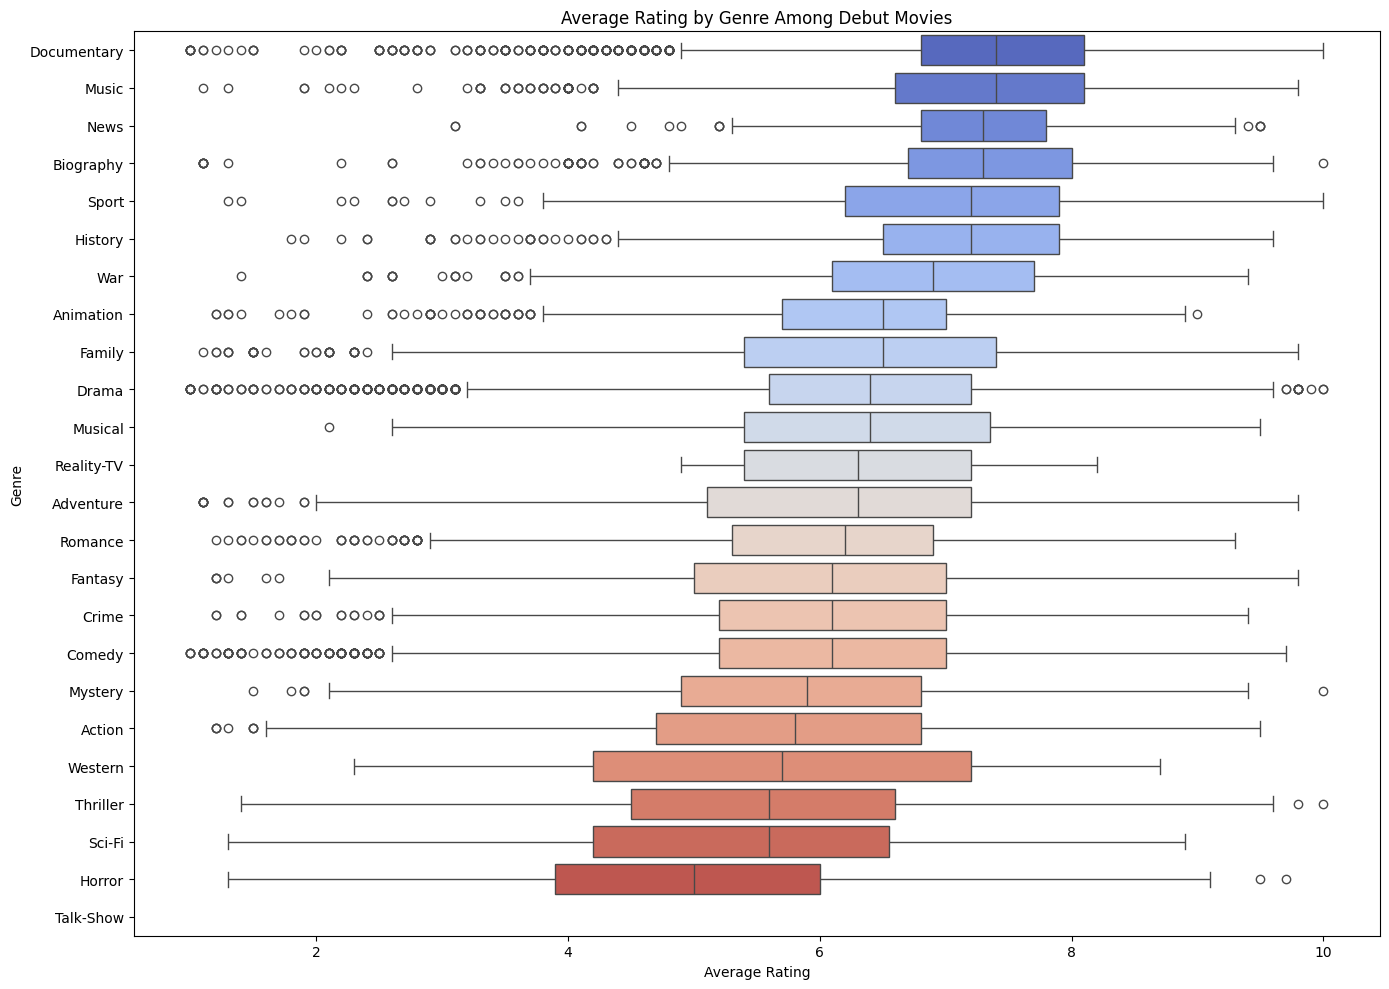

In [74]:
# Order genres by their median ratings to prepare for the box plot visualization, highlighting the average reception of debut movies by genre.
genres_ordered_by_median_ratings = genres_expanded_ratings.groupby('genre')['averageRating'].median().sort_values(ascending=False).index

# Create a box plot to compare the average ratings of debut movies across different genres.
plt.figure(figsize=(14, 10))
sns.boxplot(data=genres_expanded_ratings, x='averageRating', y='genre', palette='coolwarm', order=genres_ordered_by_median_ratings)
plt.title('Average Rating by Genre Among Debut Movies')
plt.xlabel('Average Rating')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

The genres that tend to perform better (those with high median ratings) among debut directors' movies are Documentary, Music, News, and Biography, with Documentary leading. On the lower end, genres like Western, Action, Thriller, Sci-Fi, and Horror show lower median ratings, with Horror being the least favorably received among debut movies.

The genres that show more variability in ratings (those with high IQR) among debut directors' movies are News, Documentary, suggesting that ratings within these genres are more consistent. On the lower end, Western and Sci-Fi exhibit most variability in their ratings. Horror, despite its lower median rating, also shows significant variability in how it's received.

It seems like genres associated with factual content (e.g., Documentary, News, Biography) not only perform better on average but also show less variability in their reception. This might be because they show a consistent quality or because the audience's expectations align well with the output in these genres. In constrast, creative or speculative genres (e.g., Sci-Fi, Fantasy, Horror) tend to have more variability in reception and, in some cases, lower median ratings. This might be because it is very challenging to execute these genres well or because audience's expectations for these genres are diverse. 

## Vote counts across genres among debut movies 

We can also create the same visualization for number of votes across different genres among debut movies. This helps us compare how different genres fare in terms of audience engagement and popularity. Since vote counts are vastly different among different genres, we'll use a logarithmic scale on the x-axis to accommodate this wide range.

This visualization highlightS which genres not only attract viewer interest but also inspire viewers to rate or review. It can reveal genres that are particularly engaging or popular among audiences, offering a different perspective on success than critical ratings alone.

/var/folders/1j/csv118695x53qkzhd9p2tgcc0000gn/T/ipykernel_2159/897819109.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=genres_expanded_ratings, x='numVotes', y='genre', palette='viridis', order=genres_ordered_by_median_votes)


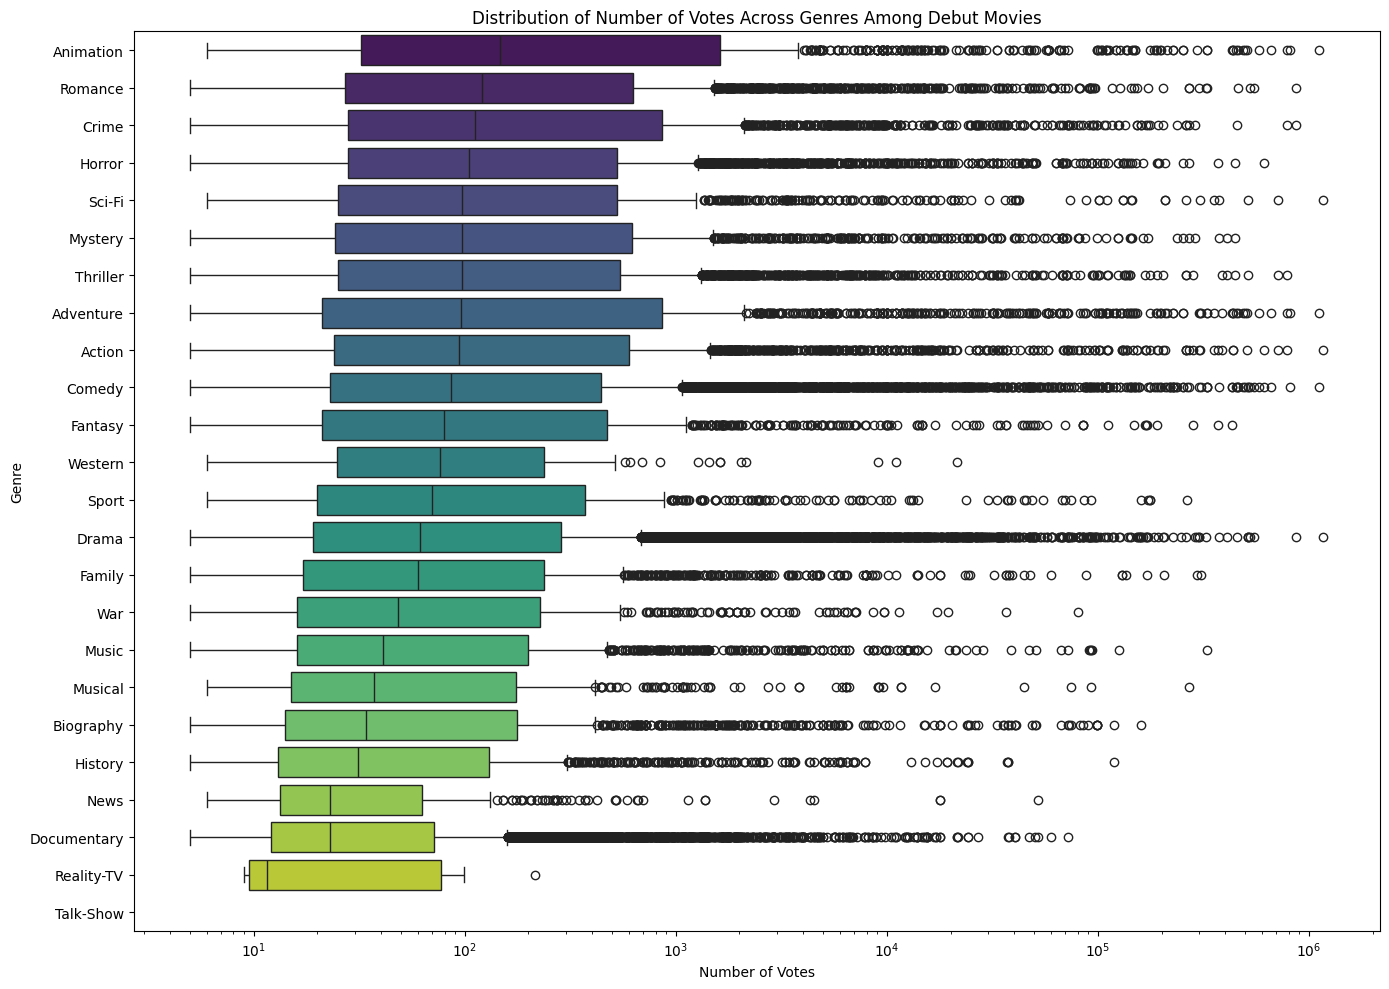

In [75]:
# Order genres by their median number of votes to analyze audience engagement with debut movies by genre.
genres_ordered_by_median_votes = genres_expanded_ratings.groupby('genre')['numVotes'].median().sort_values(ascending=False).index

# Visualize the distribution of audience votes across genres for debut movies using a box plot with a logarithmic scale.
plt.figure(figsize=(14, 10))
sns.boxplot(data=genres_expanded_ratings, x='numVotes', y='genre', palette='viridis', order=genres_ordered_by_median_votes)
plt.title('Distribution of Number of Votes Across Genres Among Debut Movies')
plt.xlabel('Number of Votes')
plt.ylabel('Genre')
plt.xscale('log')  # Use a logarithmic scale to better display the wide range of values
plt.tight_layout()
plt.show()


Animation and Romance stand out with the highest median number of votes, suggesting these genres tend to attract a high level of viewer engagement on average. This is followed closely by genres like Crime and Horror. Documentary, News, and Reality-TV show the lowest median number of votes, indicating lower average engagement from viewers for debut movies in these genres.

The interquartile range (IQR) offer additional insights into the variability of popularity within genres. For example, Animation, despite its high average engagement, shows a large IQR, indicating a wide variability in the number of votes across movies within this genre. In contrast, genres like News and Documentary, while less popular on average, exhibit smaller IQRs, suggesting more consistency in the number of votes their debut movies receive.

Overall, genres like Animation and Adventure not only show high average engagement but also a significant range in engagement levels, suggesting that while hits are possible, there's also a considerable range in audience reception. In constrast, Documentary and News genres, with their lower engagement levels, still offer a degree of predictability in audience size.

# Examining career pre-directing debut

Some first-time directors might have worked on other movies in non-directing roles before they started directing. This prior experience might influence their career longevity as a director. Therefore, in this part of our analysis, we explore the extent and nature of their involvement in movie productions prior to their directing debut. 


In [75]:
# Filtering the principal dataset for entries related to our first-time directors
# This captures all the roles they have held in any film production, not just as directors
director_roles_pre_debut = df_principals[(df_principals['nconst'].isin(debut_directors_2003_2013['nconst']))]

# Merging this data with the movies dataset to associate each role with its corresponding release year
director_roles_pre_debut = director_roles_pre_debut[['tconst', 'nconst', 'category']].merge(movies[['tconst', 'startYear']], on='tconst', how='inner')

# Further merging with the debut directors dataset to include the year of each director's first movie
# This helps in identifying work done prior to their directorial debut
director_roles_pre_debut = director_roles_pre_debut.merge(debut_directors_2003_2013, on='nconst', how='left')

# Filtering for work before their directorial debut
# This step isolates their activities in the industry prior to becoming a director
pre_debut_work = director_roles_pre_debut[director_roles_pre_debut['startYear'] < director_roles_pre_debut['firstYear']]

# Excluding entries where their role was 'self' to focus on professional roles
pre_debut_work = pre_debut_work[pre_debut_work['category'] != "self"]

# Aggregating the data to count the number of movies and list the different roles each director held before their debut
pre_debut_experience = pre_debut_work.groupby('nconst').agg({
    'tconst': 'count', 
    'category': lambda x: list(set(x))
    }).rename(columns={'tconst': 'movie_count', 'category': 'roles'})

# Initializing a DataFrame to track each director's experience prior to their debut
directors_experience = pd.DataFrame({'nconst': directors_full_filmography['nconst']}).drop_duplicates()
directors_experience['had_prior_experience'] = 0  # Initializing with 0 (no experience)

# Merging with the pre_debut_experience data to get the movies count and different roles before debut
directors_experience = directors_experience.merge(pre_debut_experience, on='nconst', how='left')

# Filling missing values (NaNs) with 0 for directors without prior experience
directors_experience['movie_count'].fillna(0, inplace=True)

# Updating the 'had_prior_experience' flag to 1 for directors who had prior experience
directors_experience.loc[directors_experience['movie_count'] > 0, 'had_prior_experience'] = 1

In [93]:
directors_experience

,nconst,had_prior_experience,movie_count,roles
0,nm1131265,0,0.0,NaN
1,nm1130611,0,0.0,NaN
2,nm0290651,0,0.0,NaN
3,nm0404033,0,0.0,NaN
4,nm0000417,1,14.0,"['archive_footage', 'actor']"
...,...,...,...,...
63164,nm4394847,0,0.0,NaN
63165,nm10527671,0,0.0,NaN
63166,nm10532602,0,0.0,NaN
63167,nm4453202,0,0.0,NaN


Let's count the number of directors for each movie count.

In [123]:
directors_experience['movie_count'].value_counts().sort_index()

movie_count
0.0      52850
1.0       5774
2.0       1820
3.0        842
4.0        473
         ...  
106.0        1
112.0        1
124.0        1
160.0        1
163.0        1
Name: count, Length: 76, dtype: int64

Looks like the majority of first-time directors (84%) did not work in other movie productions before their directing debut. Let's creating a bar chart for those who did have prior experience to a sense of the variety and frequency of roles assumed by these directors.

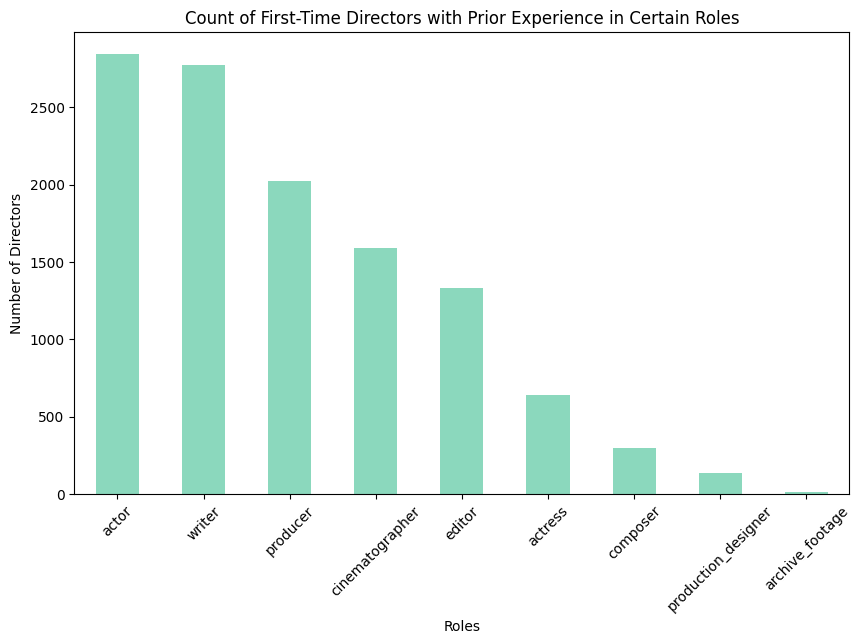

In [115]:
# Creating a bar chart to visualize the different roles taken by first-time directors before their debut

plt.figure(figsize=(10, 6))
# Flatten the list of roles and count each occurrence and create a bar chart
directors_experience.explode('roles')['roles'].value_counts().plot(kind='bar', color='#8BD8BD')

# Adding labels and title
plt.title('Count of First-Time Directors with Prior Experience in Certain Roles')
plt.xlabel('Roles')
plt.ylabel('Number of Directors')

plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.show()

Among first-time directors with prior industry experience, the most common roles are those of actors and writers. This  suggests a notable pathway into directing, where among people already in the film industry, those with substantial experience in acting or writing are more likely to transition into directing roles.

In [92]:
# save the data for future analysis 
directors_experience.to_csv('directors_pre_debut_careers.csv', index=False)